# Introduction

Welcome to the Automated Data Science hands-on Colab notebook for AutoML School 2024!

In this session, you’ll learn how to effectively use the Quick-Tune-Tool. We’ll guide you through:

* Installing `QuickTuneTool`,
* Exploring its key components,
* Utilizing meta-trained predictors to kickstart your runs,
* Loading and testing a fine-tuned model for inference.

# 🕮 Installation

The following cell installs the a library to use LLMs for feature engineering.

Restart your runtime and rerun the cell, if Colab asks for it.

In [ ]:
!pip install git+https://github.com/automl/QTT

# 🕮 Necessary Imports for the Notebook

The examples in this notebook require the following imports.
Make sure to run this cell before any other cell.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from qtt import QuickOptimizer, QuickTuner, QuickCVCLSTuner
from qtt.predictors import PerfPredictor, CostPredictor
from qtt.finetune.cv.classification import extract_task_info_metafeat, finetune_script
from ConfigSpace import (
    Categorical,
    ConfigurationSpace,
    Constant,
    EqualsCondition,
    OrConjunction,
    OrdinalHyperparameter,
)

# 🔽 Download the Meta-Dataset

To get started, we'll download the Meta-Dataset, which will allow us to explore how to meta-train a predictor.

The Meta-Dataset is available in three versions: micro, mini, and extended. For our tests, we'll be using the mini version.

In [ ]:
# @title download
%%capture
!wget https://nextcloud.tf.uni-freiburg.de/index.php/s/fQmPmB84EmwxddJ/download/mtlbm.zip
!unzip mtlbm.zip -d mtlbm

Now, let's have a look at the Meta-Dataset.

In [ ]:
# @title load the data

config = pd.read_csv("mtlbm/mini/config.csv", index_col=0)
cost = pd.read_csv("mtlbm/mini/cost.csv", index_col=0)
meta = pd.read_csv("mtlbm/mini/meta.csv", index_col=0)
curve = pd.read_csv("mtlbm/mini/curve.csv", index_col=0)
config.head()

,amp,batch_size,bss_reg,clip_grad,cotuning_reg,cutmix,decay_epochs,decay_rate,delta_reg,drop,...,sched,smoothing,sp_reg,stoch_norm,warmup_epochs,warmup_lr,weight_decay,opt_betas,data_augmentation,auto_augment
74417154365539438,False,128,0.100,1.0,2.0,0.50,20.0,0.1,0.0100,0.4,...,multistep,0.00,0.0000,False,5,0.0,0.01000,"(0.9, 0.99)",none,NaN
8461644391739478,False,4,0.001,NaN,4.0,4.00,0.0,0.1,0.0001,0.2,...,cosine,0.00,0.1000,False,10,0.0,0.10000,NaN,trivial_augment,NaN
28759971764404954,False,64,0.010,1.0,0.0,1.00,0.0,0.1,0.0100,0.4,...,plateau,0.10,0.0001,True,10,0.0,0.00010,NaN,none,NaN
13521192914230212,False,32,0.000,10.0,0.5,4.00,20.0,0.1,0.1000,0.4,...,multistep,0.00,0.0001,False,0,0.0,0.00001,"(0.9, 0.999)",trivial_augment,NaN
63905311029357793,True,2,0.100,1.0,4.0,0.25,20.0,0.5,0.0100,0.4,...,multistep,0.05,0.1000,True,10,0.0,0.00000,"(0.0, 0.99)",trivial_augment,NaN


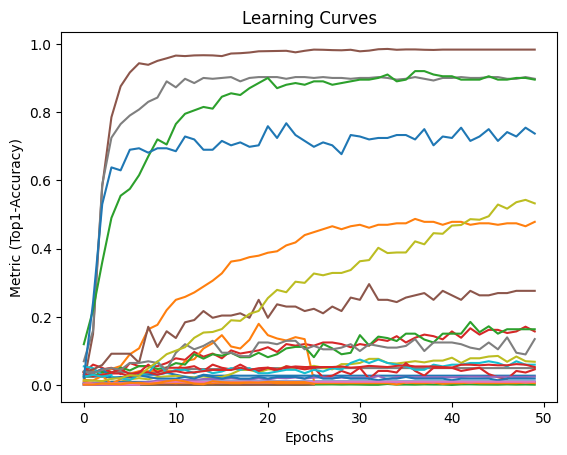

In [ ]:
# @title Plot a few learning curves

subset = curve.sample(32)

for index, row in subset.iterrows():
    plt.plot(row.values)

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Metric (Top1-Accuracy)')
plt.title('Learning Curves')

# Show plot
plt.show()

# Meta-Train Predictors

We leverage the learning curves by meta-training the Predictors

In [ ]:
X = pd.concat([config, meta], axis=1)
y = curve.values

perf_predictor = PerfPredictor().fit(X, y)

y = cost.values
cost_predictor = CostPredictor().fit(X, y)

# 🔥 Download image dataset

To demonstrate the use of QTT, we'll work with the Imagenette dataset. Given the constraints of Colab's hardware, we'll use a small subset of the images:

- **Training Set**: 40 samples per class
- **Validation Set**: 10 samples per class
- **Test Set**: 5 samples per class
This setup will allow us to showcase the capabilities of QTT while working within Colab’s limitations.


In [ ]:
# @title download + prepare
%%capture
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xzvf imagenette2-320.tgz

import os
import shutil


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def copy_files(src_dir, dest_dir, start_idx, end_idx):
    files = sorted(os.listdir(src_dir))
    total_files = len(files)
    if start_idx >= 0 and end_idx < total_files:
        for i in range(start_idx, end_idx + 1):
            shutil.copy(os.path.join(src_dir, files[i]), dest_dir)


# Create necessary directories
create_dir("dataset/train")
create_dir("dataset/val")
create_dir("dataset/test")

# Process training set
train_dir = "imagenette2-320/train"
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        create_dir(os.path.join("dataset/train", class_name))
        copy_files(class_dir, os.path.join("dataset/train", class_name), 0, 39)

# Process validation set
val_dir = "imagenette2-320/val"
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    if os.path.isdir(class_dir):
        create_dir(os.path.join("dataset/val", class_name))
        create_dir(os.path.join("dataset/test", class_name))

        total_files = len(os.listdir(class_dir))

        # Copy first 20 images to validation set
        copy_files(class_dir, os.path.join("dataset/val", class_name), 0, 19)

        # Copy last 5 images to test set
        copy_files(
            class_dir,
            os.path.join("dataset/test", class_name),
            total_files - 5,
            total_files - 1,
        )

# Define Search Space

To accommodate Colab's hardware limitations, we will make some adjustments to the Search Space. Specifically, we will:

- Limit the models to a maximum of 30 million parameters
- Reduce the maximum batch size to 64





In [ ]:
cs = ConfigurationSpace("cv-classification")
freeze = OrdinalHyperparameter("pct_to_freeze", [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ld = OrdinalHyperparameter("layer_decay", [0.0, 0.65, 0.75])
lp = OrdinalHyperparameter("linear_probing", [False, True])
sn = OrdinalHyperparameter("stoch_norm", [False, True])
sr = OrdinalHyperparameter("sp_reg", [0.0, 0.0001, 0.001, 0.01, 0.1])
d_reg = OrdinalHyperparameter("delta_reg", [0.0, 0.0001, 0.001, 0.01, 0.1])
bss = OrdinalHyperparameter("bss_reg", [0.0, 0.0001, 0.001, 0.01, 0.1])
cot = OrdinalHyperparameter("cotuning_reg", [0.0])
mix = OrdinalHyperparameter("mixup", [0.0, 0.2, 0.4, 1.0, 2.0, 4.0, 8.0])
mix_p = OrdinalHyperparameter("mixup_prob", [0.0, 0.25, 0.5, 0.75, 1.0])
cut = OrdinalHyperparameter("cutmix", [0.0, 0.1, 0.25, 0.5, 1.0, 2.0, 4.0])
drop = OrdinalHyperparameter("drop", [0.0, 0.1, 0.2, 0.3, 0.4])
smooth = OrdinalHyperparameter("smoothing", [0.0, 0.05, 0.1])
clip = OrdinalHyperparameter("clip_grad", [0, 1, 10])
amp = OrdinalHyperparameter("amp", [False, True])
opt = Categorical("opt", ["sgd", "momentum", "adam", "adamw", "adamp"])
betas = Categorical("opt_betas", ["(0.9, 0.999)", "(0.0, 0.99)", "(0.9, 0.99)", "(0.0, 0.999)"])
lr = OrdinalHyperparameter("lr", [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01])
w_ep = OrdinalHyperparameter("warmup_epochs", [0, 5, 10])
w_lr = OrdinalHyperparameter("warmup_lr", [0.0, 1e-05, 1e-06])
wd = OrdinalHyperparameter("weight_decay", [0, 1e-05, 0.0001, 0.001, 0.01, 0.1])
bs = OrdinalHyperparameter("batch_size", [8, 16, 32, 64])
mom = OrdinalHyperparameter("momentum", [0.0, 0.8, 0.9, 0.95, 0.99])
sched = Categorical("sched", ["cosine", "step", "multistep", "plateau"])
pe = OrdinalHyperparameter("patience_epochs", [2, 5, 10])
dr = OrdinalHyperparameter("decay_rate", [0.1, 0.5])
de = OrdinalHyperparameter("decay_epochs", [10, 20])
da = Categorical("data_augmentation", ["auto_augment", "random_augment", "trivial_augment", "none"])
aa = Categorical("auto_augment", ["v0", "original"])
ra_nops = OrdinalHyperparameter("ra_num_ops", [2, 3])
ra_mag = OrdinalHyperparameter("ra_magnitude", [9, 17])
cond_1 = EqualsCondition(pe, sched, "plateau")
cond_2 = OrConjunction(EqualsCondition(dr, sched, "step"), EqualsCondition(dr, sched, "multistep"))
cond_3 = OrConjunction(EqualsCondition(de, sched, "step"), EqualsCondition(de, sched, "multistep"))
cond_4 = EqualsCondition(mom, opt, "momentum")
cond_5 = OrConjunction(EqualsCondition(betas, opt, "adam"), EqualsCondition(betas, opt, "adamw"), EqualsCondition(betas, opt, "adamp"))
cond_6 = EqualsCondition(ra_nops, da, "random_augment")
cond_7 = EqualsCondition(ra_mag, da, "random_augment")
cond_8 = EqualsCondition(aa, da, "auto_augment")
cs.add(mix, mix_p, cut, drop, smooth, clip, freeze, ld, lp, sn, sr, d_reg, bss, cot, amp, opt, betas, lr, w_ep, w_lr, wd, bs, mom, sched, pe, dr, de, da, aa, ra_nops, ra_mag, cond_1, cond_2, cond_3, cond_4, cond_5, cond_6, cond_7, cond_8)
model = Categorical("model", ["deit3_small_patch16_384_in21ft1k", "dla46x_c", "edgenext_small", "edgenext_x_small", "edgenext_xx_small", "mobilevit_xs", "mobilevit_xxs", "mobilevitv2_075", "tf_efficientnet_b4_ns", "volo_d1_384", "xcit_nano_12_p8_384_dist", "xcit_small_12_p8_384_dist", "xcit_tiny_12_p8_384_dist", "xcit_tiny_24_p8_384_dist"])
cs.add(model)

# Create own Optimizer

In [ ]:
optimizer = QuickOptimizer(
    cs,
    max_fidelity=50,                # number of steps, e.g. epochs, must match the length of learning curves passed during fitting
    perf_predictor=perf_predictor,
    cost_predictor=cost_predictor,
    cost_aware=True,
    cost_factor=1.0,                # balances the importance of the cost-sensitivity by adjusting the scale of the predicted cost values, lower values
    acq_fn="ei",                    # acquisiton function to use
    explore_factor=0.1,             # xi value in the acquisition that balances exploration and exploitation
    patience=3,                     # early stopping for single configurations, if score does not improve by `tol`
    tol=0.001,                      # tolerance for early stopping
    refit=True,                     # whether the predictor is refitted during optimization
    refit_init_steps=32,            # how many inital steps to wait before we start with refitting
    refit_interval=1,               # interval of refit, 1 refits every step
    seed=42
)

## Finalize setup of optimizer
The optimizer was trained with metafeatures of the datasets.
We provide a function, that automatically extracts the metafeatures and creates the `task_info` for the quicktuner.

In [ ]:
task_info, metafeat = extract_task_info_metafeat("dataset")
optimizer.setup(256, metafeat)  # number of configurations to sample

# Create QuickTuner

The QuickTuner serves as coordinator for the optimizer, that runs the optimization loop.

In [ ]:
tuner = QuickTuner(
    finetune_script,  # script to finetune the configurations
    optimizer,
)

# Start Tune

In [ ]:
traj, runtime, history = tuner.run(task_info=task_info, fevals=100, time_budget=600)
config_id, config, score, budget, cost, info = tuner.get_incumbent()

## Plot the progress of the run

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ids = [c["config_id"] for c in history]
scores = [c["score"] for c in history]

df_traj = pd.DataFrame({"score": traj, "runtime": runtime})
df_hist = pd.DataFrame({"id": ids, "score": scores, "runtime": runtime})
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_hist, x="runtime", y="score", hue="id", palette="tab10", s=100)
sns.lineplot(data=df_traj, x="runtime", y="score", color="red", label="Incumbent")
plt.title("QuickTuner - Trajectory / History")
plt.xlabel("Runtime (s)")
plt.ylabel("Score (%)")
plt.legend([], [], frameon=False)
plt.show()

In [ ]:
print("*****   QUICKTUNE RESULTS   *****")
print("=================================")
print()
print("Best configuration found:")
print(f"Archtitecture: {config['model']}")
print(f"Score: {score*100}")
print(f"Number of epochs trained: {budget}")
print(f"Cost per epoch: {cost}")
print(f"Config: {' '.join([f'{k}={v}' for k, v in config.items()])}")
print()
print("---------------------------------")
print()
print(f"Total number of evaluated configs: {len(qt.optimizer.evaled)}")
print(f"Total number of evaluations: {len(traj)}")

# Evaluate best model on the Test-Set


First, the model must be exported. During training, the model was slightly modified to implement fine-tuning strategies, which now need to be removed. Typically, the models can be found in the experiment directory `qtt/<timestamp>` by default.

In [ ]:
from qtt.finetune.cv.classification import load_best_model

model = load_best_model(info["path"])

Load some images and predict the class

In [ ]:
model.eval()
model.to("cuda")

transform = tf.Compose(
    [
        tf.Resize(256),
        tf.CenterCrop(224),
        tf.ToTensor(),
        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
data_path = "dataset/test"
dataset = datasets.ImageFolder(data_path)

images = []
labels = []
for i in np.random.choice(len(dataset), size=10):
    img, label = dataset[i]
    images.append(img)
    labels.append(label)

input = torch.stack([transform(img) for img in images])
input = input.cuda()
with torch.no_grad():
    output = model(input)
    output = output.softmax(-1)
    _, indices = output.topk(1)

indices = indices.cpu().numpy().squeeze()

In [ ]:
import matplotlib.pyplot as plt

classes = [
    "trench",
    "english springer",
    "cassette player",
    "chain saw",
    "church",
    "french horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
]


# Define a function to display a list of PIL images
def display_images(images, nrows=5, titles=None):
    n_images = len(images)
    if titles is None:
        titles = [""] * n_images
    fig = plt.figure(figsize=(4, 8))

    for n, (image, title) in enumerate(zip(images, titles)):
        ax = fig.add_subplot(nrows, int(n_images / nrows), n + 1)
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


titles = [classes[i] for i in indices]
display_images(images, titles=titles)

# Command Line Interface

Additionaly, with installing QTT we include